In [2]:
import os
from typing import Optional, Tuple, List, Union, Callable

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tqdm import trange

# For repeatability
# seed = 3407
# torch.manual_seed(seed)
# np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
if not os.path.exists('tiny_nerf_data.npz'):
  !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

Images shape: (106, 100, 100, 3)
Poses shape: (106, 4, 4)
Focal length: 138.88887889922103
Pose
[[ 6.8935126e-01  5.3373039e-01 -4.8982298e-01 -1.9745398e+00]
 [-7.2442728e-01  5.0788772e-01 -4.6610624e-01 -1.8789345e+00]
 [ 1.4901163e-08  6.7615211e-01  7.3676193e-01  2.9699826e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


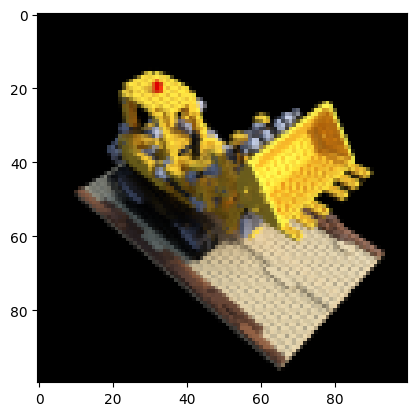

In [4]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']

print(f'Images shape: {images.shape}')
print(f'Poses shape: {poses.shape}')
print(f'Focal length: {focal}')

height, width = images.shape[1:3]
near, far = 2., 6.

n_training = 100
testimg_idx = 101
testimg, testpose = images[testimg_idx], poses[testimg_idx]

plt.imshow(testimg)
print('Pose')
print(testpose)

In [5]:
class Camera():
    def __init__(self, pose, focal, gt_img):
        self.pose = torch.tensor(pose) # 4,4 transformation matrix
        self.focal = focal
        self.gt_img = gt_img

        self.height = gt_img.shape[0]
        self.width = gt_img.shape[1]

    def origin_cart(self):
        return (self.pose[:3, -1]).flatten()
    
    def get_view_dir_cart(self):
        # (0,0,-1) shows forward in local camera frame. Multiplication by R tranlsates his into global Frame. Note that the -1 means that the camera typically looks outside of the frame, i.e., in image direction
        unit = torch.tensor([0, 0, -1], dtype=torch.float).reshape(-1, 1)
        R = self.pose[:3, :3]
        return (R @ unit).flatten()

    
    def get_ray(self, img_x, img_y):
        print("Warning: This method is slow, consider using get_all_rays instead")
        # Step 1 translate img coordinate to camera frame
        x_shifted = -(img_x - self.height * 0.5)
        y_shifted = img_y - self.height * 0.5
        cam_frame_coord = torch.tensor([y_shifted / self.focal, x_shifted / self.focal, -1]) # normalized at depth = -1, attention axis are also exchanged, -1 due to weird orientation of camera fram with z pointing towards image plane not scene
        direction = cam_frame_coord.view(3, 1) # as origin is 0 and proper vector to make sure transformation workd
        
        # Step 2 translate direction into world frame
        direction_world = self.pose[:3, :3] @ direction

        return self.origin_cart(), direction_world.flatten()
    
    def get_all_rays(self):
        # implementation of get ray but faster
        x_pos, y_pos = torch.meshgrid(
             torch.arange(height, dtype=torch.float32),
            torch.arange(width, dtype=torch.float32),
            indexing='ij'
        ) # (height, width), (height, width)

        cam_frame_coord = torch.stack([
            (y_pos-self.width * 0.5) / self.focal, -(x_pos - self.height * 0.5), -torch.ones_like(x_pos)
        ], -1) # heigh, width, (x_cam, y_cam, z_cam)
        
        R = self.pose[:3, :3] #3, 3
        rays_directions = cam_frame_coord @ R.T

        origin = self.origin_cart()

        return rays_directions, origin
        

cam = Camera(poses[0], focal, images[0])

In [6]:
train_indices = range(100)
cameras = [Camera(poses[idx], focal, images[idx]) for idx in train_indices]


# Vis Cameras

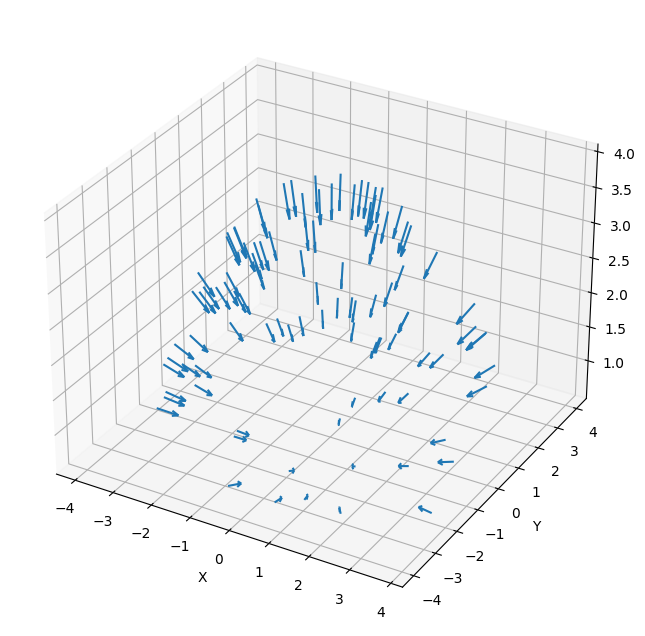

In [7]:
directions = torch.stack([camera.get_view_dir_cart() for camera in cameras], dim=0).numpy() # N, 3
origins = torch.stack([camera.origin_cart() for camera in cameras], dim=0).numpy() # N, 3

ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
_ = ax.quiver(
  origins[..., 0].flatten(),
  origins[..., 1].flatten(),
  origins[..., 2].flatten(),
  directions[..., 0].flatten(),
  directions[..., 1].flatten(),
  directions[..., 2].flatten(), length=0.5, normalize=True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('z')
plt.show()

# Vis Rays casted from Cams

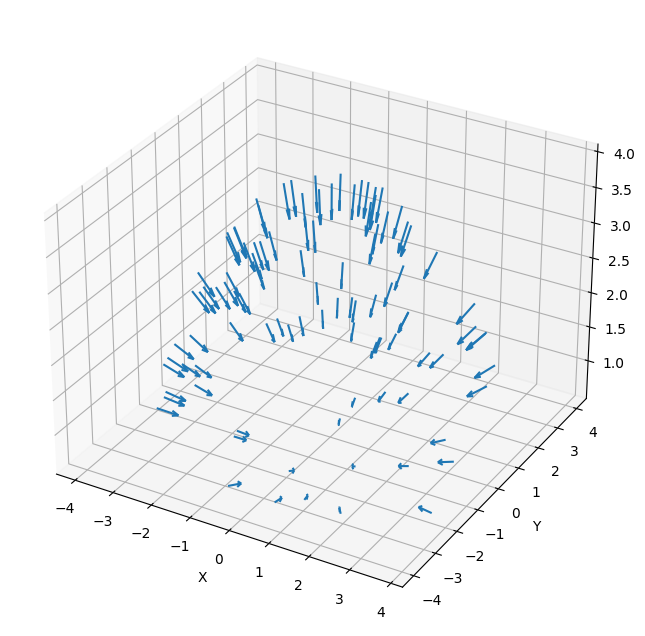

In [8]:
directions = torch.stack([camera.get_all_rays()[0][50,50] for camera in cameras], dim=0).numpy() # N, 3
origins = torch.stack([camera.origin_cart() for camera in cameras], dim=0).numpy() # N, 3

ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
_ = ax.quiver(
  origins[..., 0].flatten(),
  origins[..., 1].flatten(),
  origins[..., 2].flatten(),
  directions[..., 0].flatten(),
  directions[..., 1].flatten(),
  directions[..., 2].flatten(), length=0.5, normalize=True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('z')
plt.show()

# Create Ray Samples

In [9]:
ray_direction = torch.stack([cam.get_all_rays()[0] for cam in cameras], dim=0)
ray_origin = torch.stack([cam.origin_cart() for cam in cameras], dim=0)

near, far = 2., 6.
n_samples = 10

In [10]:
def sample_stratified(
  rays_o: torch.Tensor,
  rays_d: torch.Tensor,
  near: float,
  far: float,
  n_samples: int,
  inverse_depth: bool = False
) -> Tuple[torch.Tensor, torch.Tensor]:
  r"""
  Sample along ray from regularly-spaced bins.
  """

  t_vals = torch.linspace(0., 1., n_samples +1, device=rays_o.device)
  if not inverse_depth:
    # Sample linearly between `near` and `far`
    z_vals = near * (1.-t_vals) + far * (t_vals)
  else:
    # Sample linearly in inverse depth (disparity)
    z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))
  
  # sample uniform 
  sampling_offsets = torch.rand((*rays_d.shape[:-1], n_samples)) # N, H, W, no_samples_along_ray
  nears = z_vals[:-1] # no_samples_along_ray
  fars= z_vals[1:] # no_samples_along_ray

  sampling_location_interpolations = nears + (fars-nears) * sampling_offsets # N, H, W, no_samples_along_ray
  sampling_locations = rays_o[:, None, None, None,:] + sampling_location_interpolations[..., None] * rays_d[..., None, :] # N, H, W, no_samples_along_ray, 3

  return sampling_locations, sampling_location_interpolations

# sample_stratified(
#   rays_o, rays_d, near, far, n_samples
# )

In [11]:
# Draw stratified samples from example
rays_o = ray_origin
rays_d = ray_direction
n_samples = 8
inverse_depth = False
with torch.no_grad():
  pts, z_vals = sample_stratified(rays_o, rays_d, near, far, n_samples,
                               inverse_depth=inverse_depth)

print('Input Points')
print(pts.shape)
print('')
print('Distances Along Ray')
print(z_vals.shape)

Input Points
torch.Size([100, 100, 100, 8, 3])

Distances Along Ray
torch.Size([100, 100, 100, 8])


# Create positional encoder

In [12]:
class PositionalEncoder(nn.Module):
  r"""
  Sine-cosine positional encoder for input points.
  """
  def __init__(
    self,
    d_input: int,
    n_freqs: int,
    log_space: bool = False
  ):
    super().__init__()
    self.d_input = d_input
    self.n_freqs = n_freqs
    self.log_space = log_space
    self.d_output = d_input * (1 + 2 * self.n_freqs)
    self.embed_fns = [lambda x: x]

    # Define frequencies in either linear or log scale
    if self.log_space:
      freq_bands = 2.**torch.linspace(0., self.n_freqs - 1, self.n_freqs)
    else:
      freq_bands = torch.linspace(2.**0., 2.**(self.n_freqs - 1), self.n_freqs)

    # Alternate sin and cos
    for freq in freq_bands:
      self.embed_fns.append(lambda x, freq=freq: torch.sin(x * freq))
      self.embed_fns.append(lambda x, freq=freq: torch.cos(x * freq))
  
  def forward(
    self,
    x
  ) -> torch.Tensor:
    r"""
    Apply positional encoding to input.
    """
    return torch.concat([fn(x) for fn in self.embed_fns], dim=-1)

# Build NERF model

In [13]:
class NerfModel(nn.Module):
    def __init__(self, dim_position, dim_direction):
        self.module_pos = nn.Sequential(
            nn.Linear(dim_position, 256),
            nn.ReLU(),
            *[nn.Linear(256, 256), nn.ReLU()] * 7
        )

        self.ff_density = nn.Linear(256, 1)
        self.module_color =nn.Sequential(
            nn.Linear(256 + dim_direction, 128),
            nn.ReLU(),
            nn.Linear(128, 3)

        ) 
    def forward(self, pos_enc, dir_enc):
        x = self.module_pos(pos_enc)
        sigma = self.ff_density(x)
        x = torch.concat([x, dir_enc], dim=-1)
        color = self.module_color(x)
        
        return sigma, color

In [14]:
def render(
        samplig_locations: torch.Tensor, # N, H, W, no_samples_along_ray, 3
        rays_d: torch.Tensor, # N, H, W, 3
        model,
        enocder_pos,
        encoder_dir,
):
   rays_d = rays_d[..., None, :].expand(samplig_locations.shape) # N, H, W, no_samples_along_ray, 3
   distances = torch.norm(samplig_locations[..., 1:, :] - samplig_locations[..., :-1, :], dim=-1)
   distances_flat = distances.view(-1)
   locations_flat = samplig_locations.view(-1, 3) # N, 3
   dirs_flat = rays_d.view(-1, 3) # N, 3


   pos_enc = enocder_pos(locations_flat) # N, n_embd
   dir_enc = encoder_dir(dirs_flat) # N, n_embd
   sigma, color = model(pos_enc, dir_enc) # N, 1 / N, 3